In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import floor

from gpflow.utilities import print_summary, set_trainable, to_default_float
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '4'

from sklearn.metrics import mean_squared_error, mean_absolute_error
from properscoring import crps_gaussian
import datetime

import sys
sys.path.append('../../src')
from data_preparation import get_birth_data, separate_data, train_test_normalise
from useful_fun import plot_sliding_window, number_outof_CI, split_dataframe_by_position


In [2]:
# load data

# whole dataset
data = get_birth_data()
weekday_df = data[data.weekday==1]
weekend_df = data[data.weekday==0]
# weekday_x, weekday_y = separate_data(weekday_df) 
# weekend_x, weekend_y = separate_data(weekend_df)

# get date for x-axis in plots: mm-yyyy
def get_xticks(df):
    dff = df.groupby(by='m-y').first()
    pos = dff.ids; pos = pos[1:]
    labels = dff.index; labels = labels[1:]
    return pos, labels

# Sliding Window
### Two-latent function model with VGP

        y = f(x) + g(x) + e
        f = GP(0, RBF)
        g = GP(0, Periodic)

        l = InvGama()
        sigma = Gamma()

In [3]:
def optimise_model(model, epochs=50):

    set_trainable(model.q_mu, False)
    set_trainable(model.q_sqrt, False)

    variational_vars = [(model.q_mu, model.q_sqrt)]
    natgrad_opt = gpflow.optimizers.NaturalGradient(gamma=0.1)
    adam_vars = model.trainable_variables
    adam_opt = tf.optimizers.Adam(0.01)

    @tf.function
    def optimisation_step():
        natgrad_opt.minimize(model.training_loss, variational_vars)
        adam_opt.minimize(model.training_loss, adam_vars)

    for epoch in range(1, epochs + 1):
        optimisation_step()

In [4]:
def slidingwindow_alg(dat, splits, window_size, epochs=50, l0=170, p=365):    
    split_dataframes = split_dataframe_by_position(dat, splits)

    # evaluation lists
    ELBO_train = []
    mse_train = []; mae_train = []; n_outof_CI_train = []
    mse_test = [];  mae_test = [];  n_outof_CI_test = []
    crps_train = []; crps_test = []

    # window sizes
    iterations = splits-window_size

    # which iteration to plot
    iteration_plot = [int(floor(iterations/2)), iterations-1]
    print('iterations to go through, plot: ', iterations, iteration_plot)

    for i in range(splits-window_size):
        # create new dataframe
        df = pd.DataFrame()

        # select data
        for df_ind in range(window_size):
            if df_ind == 0:
                df = split_dataframes[i]
            else :
                df = pd.concat([df, split_dataframes[i+df_ind]], axis=0)

        whole_data = pd.concat([df, split_dataframes[i+window_size]], axis=0)
        pos, labels = get_xticks(whole_data)

        # normalise & separate data
        df_train = df; df_test = split_dataframes[i+window_size]
        df_train, df_test = train_test_normalise(df_train, df_test)
        x_train, y_train = separate_data(df_train)
        x_test, y_test = separate_data(df_test)
        
        # build model
        if i == 0:
            kernel = gpflow.kernels.RBF(lengthscales = l0, variance = 1) + gpflow.kernels.Periodic(gpflow.kernels.Matern32(), period=p)
        else:
            # re-optimize from starting values = optimizes hyperparameters in previous window
            kernel = gpflow.kernels.RBF(lengthscales = l_0, variance = v0) + gpflow.kernels.Periodic(gpflow.kernels.Matern32(lengthscales=l1, variance=v1), period=p_1)
        model = gpflow.models.VGP((x_train, y_train), kernel, gpflow.likelihoods.Gaussian(), num_latent_gps=1)
        if i != 0: 
            model.q_mu.assign(q_mu)
            model.q_sqrt.assign(q_sqrt)
            model.likelihood.variance.assign(v)
        model.likelihood.variance.prior = tfp.distributions.Normal(to_default_float(0), to_default_float(1))
        model.kernel.kernels[0].lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(1), to_default_float(1))
        model.kernel.kernels[0].variance.prior = tfp.distributions.Gamma(to_default_float(1), to_default_float(1))
        model.kernel.kernels[1].base_kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(1), to_default_float(1))
        model.kernel.kernels[1].base_kernel.variance.prior = tfp.distributions.Gamma(to_default_float(1), to_default_float(1))
        model.kernel.kernels[1].period.prior = tfp.distributions.Uniform(to_default_float(0), to_default_float(1))

        # optimise/train step
        optimise_model(model, epochs=epochs)

        # save hyperparameters
        l_0 = model.kernel.kernels[0].lengthscales.numpy()
        l1 = model.kernel.kernels[1].base_kernel.lengthscales.numpy()
        v0 = model.kernel.kernels[0].variance.numpy()
        v1 = model.kernel.kernels[1].base_kernel.variance.numpy()
        p_1 = model.kernel.kernels[1].period.numpy()
        q_mu = model.q_mu.numpy(); q_sqrt = model.q_sqrt.numpy()
        v = model.likelihood.variance.numpy()

        # predict
        mean_train, var_train = model.predict_y(x_train)
        mean_test, var_test = model.predict_y(x_test)

        # evaluate
        ELBO_train.append(model.elbo().numpy())
        mse_train.append(mean_squared_error(y_train, mean_train)); n_outof_CI_train.append(number_outof_CI(y_train, mean_train, var_train))
        mse_test.append(mean_squared_error(y_test, mean_test)); n_outof_CI_test.append(number_outof_CI(y_test, mean_test, var_test))
        crps_train.append(np.mean(crps_gaussian(y_train, mean_train, np.sqrt(var_train)))); crps_test.append(np.mean(crps_gaussian(y_test, mean_test, np.sqrt(var_test))))

        if i in iteration_plot:
            plot_sliding_window(x_train, x_test, y_train, y_test, mean_train, mean_test, var_train, var_test, pos, labels, iteration=i)
        

    # Average evaluation metrics
    print('ELBO Avg: ', np.mean(ELBO_train))
    print('Train Avg. MSE, points outside CI: ', np.mean(mse_train), np.mean(n_outof_CI_train))
    print('Test Avg. MSE, points outside CI: ', np.mean(mse_test),  np.mean(n_outof_CI_test))
    print('CRPS train, test: ', np.mean(crps_train), np.mean(crps_test))

    # histogram of CI
    fig, ax = plt.subplots(1,2)
    ax[0].hist(n_outof_CI_train, bins=50)
    ax[0].set_title('Train')
    ax[1].hist(n_outof_CI_test, bins=50)
    ax[1].set_title('Test')
    plt.title('Histogram of number of points that lie outside 95% CI')
    plt.show()

    # evolution of metrics
    fig, ax = plt.subplots(1,2, figsize=(8,4))
    ax[0].plot(np.linspace(1,iterations, iterations), mse_train, '-', color='C0')
    ax[0].plot(np.linspace(1,iterations, iterations), mse_test, '-', color='orange')
    ax[0].set_ylabel('MSE')
    ax[0].set_xlabel('Windows')
    ax[1].plot(np.linspace(1,iterations, iterations), crps_train, '-', color='C0', label='Train set')
    ax[1].plot(np.linspace(1,iterations, iterations), crps_test, '-', color='orange', label='Test set')
    ax[1].set_ylabel('CRPS')
    ax[1].set_xlabel('Windows')
    plt.legend()
    plt.show()

    return print_summary(model, fmt='notebook')

# Weekday

iterations to go through, plot:  55 [27, 54]


2022-08-30 21:01:09.173002: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-30 21:01:09.778939: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9646 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:b1:00.0, compute capability: 7.5
2022-08-30 21:01:09.998509: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-08-30 21:01:14.889643: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x748fb50


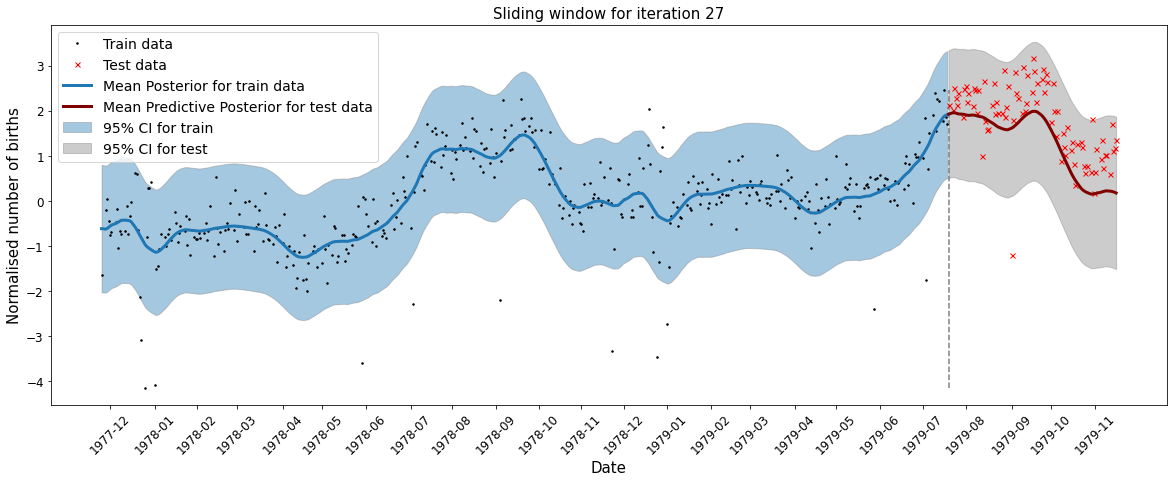

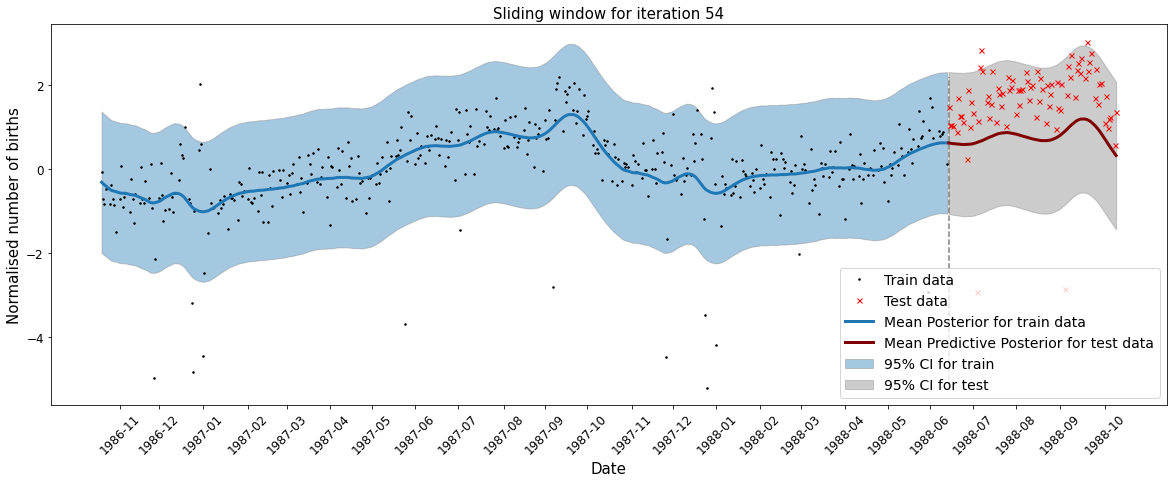

ELBO Avg:  -482.7648195694698
Train Avg. MSE, points outside CI:  0.45241842267429944 16.09090909090909
Test Avg. MSE, points outside CI:  0.6616763253035907 3.963636363636364
CRPS train, test:  0.3359520011132819 0.4229038397505532


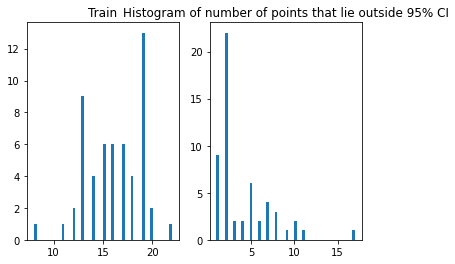

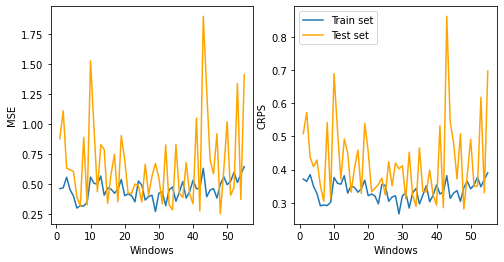

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.kernels[0].variance,Parameter,Softplus,Gamma,True,(),float64,0.07270623685336856
VGP.kernel.kernels[0].lengthscales,Parameter,Softplus,InverseGamma,True,(),float64,159.63416775642807
VGP.kernel.kernels[1].base_kernel.variance,Parameter,Softplus,Gamma,True,(),float64,3.754332209588886
VGP.kernel.kernels[1].base_kernel.lengthscales,Parameter,Softplus,InverseGamma,True,(),float64,0.6173651427639243
VGP.kernel.kernels[1].period,Parameter,Softplus,Uniform,True,(),float64,364.12516839617945
VGP.likelihood.variance,Parameter,Softplus + Shift,Normal,True,(),float64,0.694336798988056
VGP.num_data,Parameter,Identity,,False,(),int32,430
VGP.q_mu,Parameter,Identity,,False,"(430, 1)",float64,[[-1.61297291e-01...
VGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 430, 430)",float64,"[[[1.03533728e-01, 0.00000000e+00, 0.00000000e+00..."


In [7]:
slidingwindow_alg(weekday_df, 60, 5, epochs=30)

# Weekend

iterations to go through, plot:  55 [27, 54]


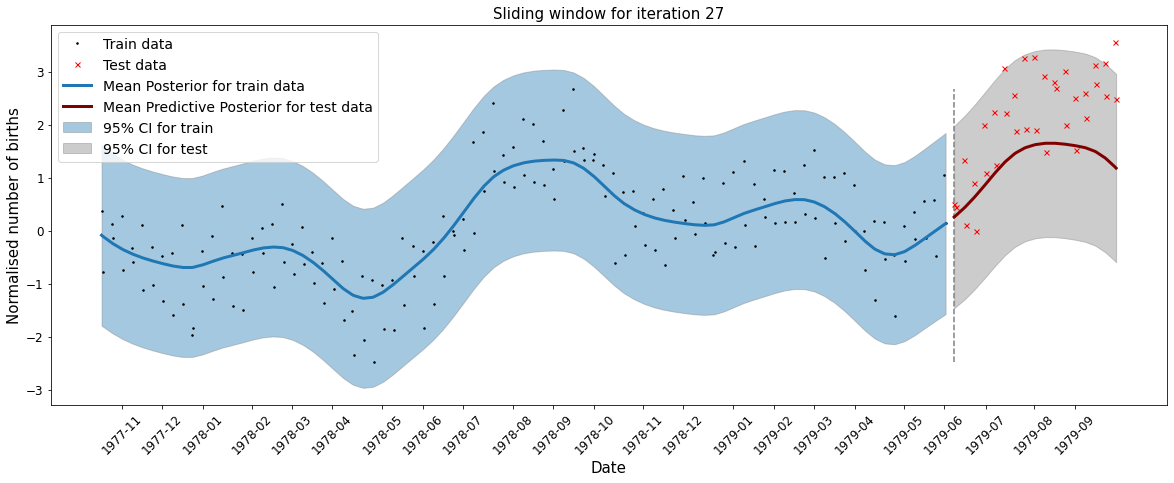

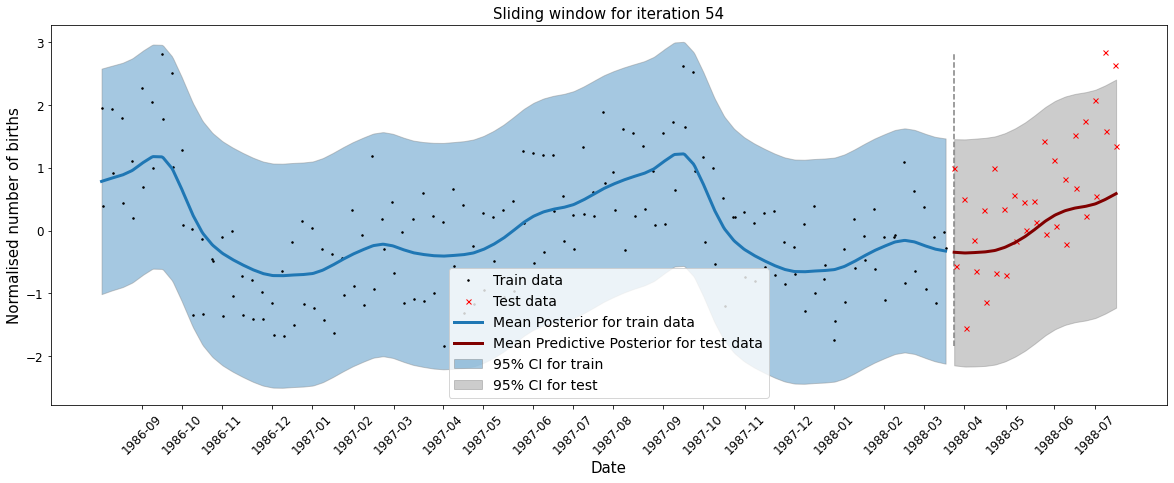

ELBO Avg:  -189.91229939001022
Train Avg. MSE, points outside CI:  0.37765041018287404 0.4909090909090909
Test Avg. MSE, points outside CI:  0.582961456606651 0.6
CRPS train, test:  0.3607404379777495 0.4347131158182522


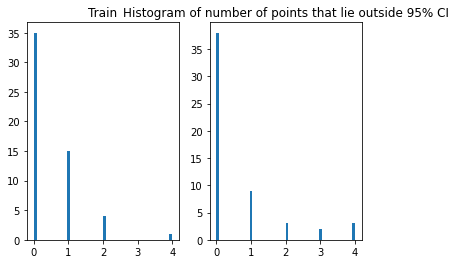

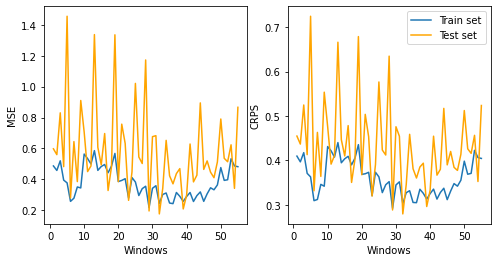

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.kernels[0].variance,Parameter,Softplus,Gamma,True,(),float64,0.0070580786458894155
VGP.kernel.kernels[0].lengthscales,Parameter,Softplus,InverseGamma,True,(),float64,162.45511730348994
VGP.kernel.kernels[1].base_kernel.variance,Parameter,Softplus,Gamma,True,(),float64,0.2869212883223723
VGP.kernel.kernels[1].base_kernel.lengthscales,Parameter,Softplus,InverseGamma,True,(),float64,0.3121412062117629
VGP.kernel.kernels[1].period,Parameter,Softplus,Uniform,True,(),float64,364.5915298863193
VGP.likelihood.variance,Parameter,Softplus + Shift,Normal,True,(),float64,0.7842258770469265
VGP.num_data,Parameter,Identity,,False,(),int32,170
VGP.q_mu,Parameter,Identity,,False,"(170, 1)",float64,[[1.44640692e+00...
VGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 170, 170)",float64,"[[[4.31318017e-01, 0.00000000e+00, 0.00000000e+00..."


In [9]:
slidingwindow_alg(weekend_df, 60, 5, epochs=30)